In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
cluster_center = pd.read_csv("./data/cluster_center.csv")
clustered_data = pd.read_csv("./data/spotify_songs_clustered.csv")

In [4]:
clustered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15405 entries, 0 to 15404
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   danceability             15405 non-null  float64
 1   energy                   15405 non-null  float64
 2   key                      15405 non-null  float64
 3   loudness                 15405 non-null  float64
 4   speechiness              15405 non-null  float64
 5   acousticness             15405 non-null  float64
 6   instrumentalness         15405 non-null  float64
 7   valence                  15405 non-null  float64
 8   tempo                    15405 non-null  float64
 9   lyrics_sentiment         15405 non-null  float64
 10  album_name_sentiment     15405 non-null  float64
 11  track_name_sentiment     15405 non-null  float64
 12  playlist_name_sentiment  15405 non-null  float64
 13  genre_edm                15405 non-null  bool   
 14  genre_latin           

In [5]:
for col in ['genre_edm', 'genre_latin', 'genre_pop', 'genre_r&b', 'genre_rap', 'genre_rock']:
    clustered_data[col] = clustered_data[col].astype('float32')

In [6]:
from sklearn.model_selection import train_test_split

X = clustered_data.drop('cluster', axis=1)
y = clustered_data['cluster']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [7]:
"""
Preparing dataset to keras
"""

X_train = X_train.fillna(0)
X_val = X_val.fillna(0)
X_test = X_test.fillna(0)

X_train = X_train.apply(pd.to_numeric)
X_val = X_val.apply(pd.to_numeric)
X_test = X_test.apply(pd.to_numeric)

X_train = X_train[y_train != -1]
y_train = y_train[y_train != -1]

X_val = X_val[y_val != -1]
y_val = y_val[y_val != -1]

X_test = X_test[y_test != -1]
y_test = y_test[y_test != -1]


In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

num_clusters = len(y.unique())

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_clusters, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1280      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 29)                957       
                                                                 
Total params: 4,317
Trainable params: 4,317
Non-trainable params: 0
_________________________________________________________________


In [9]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=10)


Epoch 1/100
641/641 [==============================] - 2s 2ms/step - loss: 1.2769 - accuracy: 0.6841 - val_loss: 0.4374 - val_accuracy: 0.9020
Epoch 2/100
641/641 [==============================] - 1s 2ms/step - loss: 0.4613 - accuracy: 0.8855 - val_loss: 0.2353 - val_accuracy: 0.9300
Epoch 3/100
641/641 [==============================] - 1s 2ms/step - loss: 0.2944 - accuracy: 0.9168 - val_loss: 0.1484 - val_accuracy: 0.9587
Epoch 4/100
641/641 [==============================] - 1s 2ms/step - loss: 0.2045 - accuracy: 0.9378 - val_loss: 0.1025 - val_accuracy: 0.9580
Epoch 5/100
641/641 [==============================] - 1s 2ms/step - loss: 0.1581 - accuracy: 0.9508 - val_loss: 0.0739 - val_accuracy: 0.9683
Epoch 6/100
641/641 [==============================] - 1s 2ms/step - loss: 0.1248 - accuracy: 0.9600 - val_loss: 0.0496 - val_accuracy: 0.9875
Epoch 7/100
641/641 [==============================] - 1s 2ms/step - loss: 0.1044 - accuracy: 0.9639 - val_loss: 0.0403 - val_accuracy: 0.9838

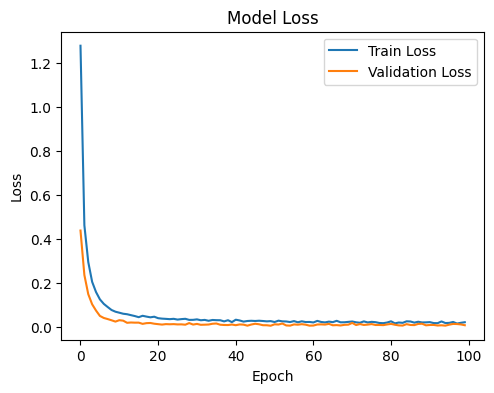

In [10]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

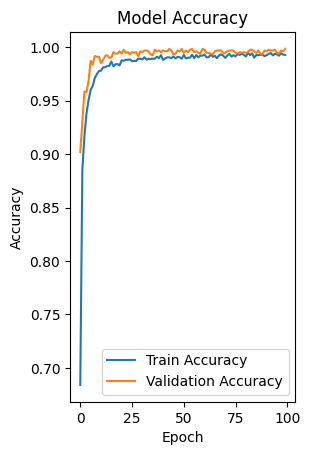

In [11]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [12]:
model.save('cluster_prediction.h5')
